In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
import random
import math
from copy import deepcopy
from tqdm import trange
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
import shap
from lime import lime_tabular
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

import gdown
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv1D, Dense, Dropout, Add, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, Add, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

2025-12-19 06:56:42.429181: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766127402.452144   19897 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766127402.459268   19897 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766127402.478486   19897 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766127402.478505   19897 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766127402.478508   19897 computation_placer.cc:177] computation placer alr

In [2]:
drive_link = 'https://drive.google.com/file/d/1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0/view?usp=sharing'
file_id = drive_link.split('/d/')[1].split('/')[0]
gdown_url = f'https://drive.google.com/uc?id={file_id}'
output_file = 'sepsis_data.csv'
gdown.download(gdown_url, output_file, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0
From (redirected): https://drive.google.com/uc?id=1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0&confirm=t&uuid=24f277df-1059-4923-8a02-6e788c739a6b
To: /kaggle/working/sepsis_data.csv
100%|██████████| 779M/779M [00:03<00:00, 226MB/s] 


'sepsis_data.csv'

In [3]:
# gpus = tf.config.list_physical_devices('GPU')
# if not gpus: raise RuntimeError("GPU NOT FOUND")
# print(f"GPU: {gpus[0].name}")
# tf.config.set_visible_devices(gpus[0], 'GPU')

# --------------------- 3. Load 1,000 Patients ---------------------
def load_1000(fp, n=1000):
    df = pd.read_csv(fp, dtype={'Patient_ID':'str','SepsisLabel':'int8','ICULOS':'int16'})
    df = df.sort_values(['Patient_ID','ICULOS'])
    drop = [c for c in df.columns if 'observed' in c.lower()] + ['HospAdmTime','Age']
    df = df.drop(columns=[c for c in drop if c in df.columns])
    feats = [c for c in df.columns if c not in ['Patient_ID','SepsisLabel','ICULOS']]
    df[feats] = df.groupby('Patient_ID')[feats].ffill().bfill().fillna(0)
    kept = df['Patient_ID'].unique()[:n]
    df = df[df['Patient_ID'].isin(kept)].reset_index(drop=True)
    print(f"Kept {len(kept)} patients → {len(df)} rows")
    return df, feats

df, feature_cols = load_1000("/kaggle/working/sepsis_data.csv", n=200)

Kept 200 patients → 7692 rows


In [5]:
def make_seq(df, L=10):
    X, y = [], []
    for _, g in df.groupby('Patient_ID'):
        f, l = g[feature_cols].values, g['SepsisLabel'].values
        if len(f) < L:
            pad = L - len(f)
            f = np.vstack([np.zeros((pad, f.shape[1])), f])
            l = np.concatenate([np.zeros(pad), l])
        for i in range(len(f) - L + 1):
            X.append(f[i:i+L])
            y.append(1 if np.any(l[i:i+L]) else 0)
    return np.array(X, np.float32), np.array(y, np.int8)

X_all, y_all = make_seq(df)
print(f"Sequences: {X_all.shape} | Pos:{y_all.sum()} Neg:{len(y_all)-y_all.sum()}")

Sequences: (5896, 10, 36) | Pos:158 Neg:5738


In [6]:
def decision_tree_undersampling(X, y, target_samples=35000):
    majority = np.where(y == 0)[0]
    if len(majority) <= target_samples: return X, y
    np.random.shuffle(majority)
    subset = majority[:min(50000, len(majority))]
    X_flat = X[subset].reshape(-1, X.shape[-1])
    y_flat = np.repeat(y[subset], X.shape[1])
    dt = DecisionTreeClassifier(max_depth=5, random_state=42).fit(X_flat, y_flat)
    selected = np.random.choice(subset, size=target_samples, replace=False)
    minority = np.where(y == 1)[0]
    idx = np.concatenate([selected, minority])
    return X[idx], y[idx]

In [7]:
def decision_tree_upsampling(X, y, target_samples=27000):
    minority = np.where(y == 1)[0]
    if len(minority) >= target_samples: return X, y
    need = target_samples - len(minority)
    X_flat = X.reshape(-1, X.shape[-1])
    y_flat = np.repeat(y, X.shape[1])
    dt = DecisionTreeClassifier(max_depth=5, random_state=42).fit(X_flat, y_flat)
    synth = []
    for _ in range(need):
        base = X[np.random.choice(minority)].copy()
        for t in range(X.shape[1]):
            for f in range(X.shape[2]):
                if dt.feature_importances_[f] > 0.01:
                    base[t,f] += np.random.normal(0, dt.feature_importances_[f]*0.1)
        synth.append(base)
    synth = np.array(synth)
    return np.concatenate([X, synth]), np.concatenate([y, np.ones(need, dtype=np.int8)])

# Apply balancing
X_all, y_all = decision_tree_undersampling(X_all, y_all, target_samples=20000)
X_all, y_all = decision_tree_upsampling(X_all, y_all, target_samples=15000)
print(f"Balanced: {X_all.shape} | Pos:{y_all.sum()} Neg:{len(y_all)-y_all.sum()}")

Balanced: (20738, 10, 36) | Pos:15000 Neg:5738


In [8]:
scaler = StandardScaler()
X_flat = X_all.reshape(-1, X_all.shape[-1])
X_scaled_flat = scaler.fit_transform(X_flat)
X_scaled = X_scaled_flat.reshape(X_all.shape)

# --------------------- 7. BiLSTM Model ---------------------
def create_model(n_features, lr=1e-3, dropout=0.2):
    inp = Input(shape=(10, n_features))
    x = Bidirectional(LSTM(64, return_sequences=True))(inp)
    x = BatchNormalization()(x); x = Dropout(dropout)(x)
    x = Bidirectional(LSTM(32, return_sequences=True))(x)
    x = BatchNormalization()(x); x = Dropout(dropout)(x)
    x = GlobalAveragePooling1D()(x)
    out = Dense(1, activation='sigmoid')(x)
    m = Model(inp, out)
    m.compile(Adam(learning_rate=lr), 'binary_crossentropy')
    return m

In [9]:
!pip install lime

In [ ]:
def cuckoo_search(objective_func, bounds, n_nests=2, pa=0.25, alpha=0.1, n_iter=2,
                  levy_lambda=1.5, minimize=True, verbose_prefix=""):
    n_params = len(bounds)
    param_names = list(bounds.keys())
    
    # Initialize nests (solutions)
    nests = []
    for _ in range(n_nests):
        nest = {}
        for name, (low, high, p_type) in bounds.items():
            if p_type == 'float':
                nest[name] = random.uniform(low, high)
            elif p_type == 'int':
                nest[name] = random.randint(int(low), int(high))
        nests.append(nest)
    
    # Evaluate initial population
    fitness = [objective_func(nest) for nest in nests]
    
    # Best solution
    best_idx = np.argmin(fitness) if minimize else np.argmax(fitness)
    best_nest = deepcopy(nests[best_idx])
    best_fitness = fitness[best_idx]
    
    for _ in trange(n_iter, desc=f"{verbose_prefix}Cuckoo Search"):
        # Generate new cuckoos via Lévy flight
        new_nests = []
        for nest in nests:
            cuckoo = deepcopy(nest)
            
            # Lévy flight step
            sigma = (math.gamma(1 + levy_lambda) * math.sin(math.pi * levy_lambda / 2) /
                     (math.gamma((1 + levy_lambda) / 2) * levy_lambda * 2**((levy_lambda - 1)/2))) ** (1/levy_lambda)
            step = np.random.normal(0, sigma**2, n_params) / (np.abs(np.random.normal(0, 1, n_params)) ** (1/levy_lambda))
            step_size = alpha * step * (np.array(list(best_nest.values())) - np.array(list(cuckoo.values())))
            
            new_cuckoo = {}
            for j, name in enumerate(param_names):
                low, high, p_type = bounds[name]
                val = cuckoo[name] + step_size[j]
                if p_type == 'float':
                    val = np.clip(val, low, high)
                else:  # int
                    val = int(round(np.clip(val, low, high)))
                new_cuckoo[name] = val
            new_nests.append(new_cuckoo)
        
        # Evaluate new solutions
        new_fitness = [objective_func(n) for n in new_nests]
        for i in range(n_nests):
            if (minimize and new_fitness[i] < fitness[i]) or (not minimize and new_fitness[i] > fitness[i]):
                nests[i] = deepcopy(new_nests[i])
                fitness[i] = new_fitness[i]
        
        # Abandon fraction of worst nests
        n_abandon = max(1, int(pa * n_nests))
        worst_idxs = np.argsort(fitness)[-n_abandon:] if minimize else np.argsort(fitness)[:n_abandon]
        for idx in worst_idxs:
            nests[idx] = {name: random.uniform(low, high) if p_type == 'float' else random.randint(int(low), int(high))
                          for name, (low, high, p_type) in bounds.items()}
            fitness[idx] = objective_func(nests[idx])
        
        # Update global best
        curr_best_idx = np.argmin(fitness) if minimize else np.argmax(fitness)
        if (minimize and fitness[curr_best_idx] < best_fitness) or (not minimize and fitness[curr_best_idx] > best_fitness):
            best_nest = deepcopy(nests[curr_best_idx])
            best_fitness = fitness[curr_best_idx]
    
    return best_nest, best_fitness


In [ ]:
class Bat:
    def __init__(self, dim, bounds, minimize=True):
        self.pos = np.random.uniform(bounds[:, 0], bounds[:, 1], dim)
        self.vel = np.zeros(dim)
        self.best_pos = self.pos.copy()
        self.loudness = random.uniform(1.0, 2.0)
        self.pulse_rate = 0.0
        self.fitness = None
        self.best_fitness = -np.inf if not minimize else np.inf
        self.minimize = minimize


def bat_algorithm(objective_func, bounds_dict, num_bats=3, num_iter=2,
                  fmin=0.0, fmax=2.0, alpha=0.95, gamma=0.9, minimize=True, verbose_prefix=""):
    param_names = list(bounds_dict.keys())
    n_params = len(param_names)
    bounds = np.array([bounds_dict[name][:2] for name in param_names])
    p_types = [bounds_dict[name][2] for name in param_names]
    
    bats = [Bat(n_params, bounds, minimize) for _ in range(num_bats)]
    
    # Initial evaluation
    for bat in bats:
        params = {name: bat.pos[i] if p_types[i] == 'float' else int(round(bat.pos[i]))
                  for i, name in enumerate(param_names)}
        bat.fitness = objective_func(params)
        bat.best_pos = bat.pos.copy()
        bat.best_fitness = bat.fitness
    
    # Global best
    best_idx = np.argmin([b.best_fitness for b in bats]) if minimize else np.argmax([b.best_fitness for b in bats])
    global_best_pos = bats[best_idx].best_pos.copy()
    global_best_fitness = bats[best_idx].best_fitness
    
    print(f"{verbose_prefix}Initial Best Fitness: {global_best_fitness:.5f}")
    
    for t in trange(num_iter, desc=f"{verbose_prefix}Bat Algorithm"):
        avg_loudness = np.mean([b.loudness for b in bats])
        
        for bat in bats:
            # Update frequency and velocity
            freq = fmin + (fmax - fmin) * random.random()
            bat.vel += (bat.pos - global_best_pos) * freq
            new_pos = bat.pos + bat.vel
            
            # Local search around global best
            if random.random() > bat.pulse_rate:
                new_pos = global_best_pos + np.random.uniform(-1, 1, n_params) * avg_loudness
            
            new_pos = np.clip(new_pos, bounds[:, 0], bounds[:, 1])
            
            # Prepare candidate parameters
            candidate_pos = new_pos.copy()
            candidate_params = {}
            for j, name in enumerate(param_names):
                val = candidate_pos[j]
                if p_types[j] == 'int':
                    val = int(round(val))
                candidate_pos[j] = val
                candidate_params[name] = val
            
            new_fitness = objective_func(candidate_params)
            
            # Accept new solution if better and random < loudness
            better = (new_fitness < bat.fitness) if minimize else (new_fitness > bat.fitness)
            if better and random.random() < bat.loudness:
                bat.pos = candidate_pos
                bat.fitness = new_fitness
                bat.loudness *= alpha
                bat.pulse_rate = 1 - np.exp(-gamma * (t + 1))
            
            # Update personal best
            if (minimize and bat.fitness < bat.best_fitness) or (not minimize and bat.fitness > bat.best_fitness):
                bat.best_pos = bat.pos.copy()
                bat.best_fitness = bat.fitness
            
            # Update global best
            if (minimize and bat.fitness < global_best_fitness) or (not minimize and bat.fitness > global_best_fitness):
                global_best_pos = bat.pos.copy()
                global_best_fitness = bat.fitness
        
        print(f"{verbose_prefix}Iteration {t+1}/{num_iter} | Best Fitness: {global_best_fitness:.5f}")
    
    # Final best parameters
    final_params = {name: global_best_pos[i] if p_types[i] == 'float' else int(round(global_best_pos[i]))
                    for i, name in enumerate(param_names)}
    
    return final_params, global_best_fitness


In [ ]:
def create_model(n_features, lr=1e-3, dropout=0.2):
    inputs = Input(shape=(10, n_features))
    x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    x = Bidirectional(LSTM(32, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['AUC'])
    return model


In [ ]:
def objective_function(params, X_train, y_train, X_val, y_val, n_features):
    model = create_model(n_features, lr=params['lr'], dropout=params['dropout'])
    
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=5,
                        batch_size=128,
                        verbose=0)
    
    # Use validation AUC
    if 'val_auc' in history.history:
        val_auc = max(history.history['val_auc'])
    else:
        y_pred = model.predict(X_val, verbose=0).flatten()
        val_auc = roc_auc_score(y_val, y_pred)
    
    return -val_auc  # Negative because we minimize

In [ ]:
def explain_with_lime(model, X_sample, feature_names, instance_idx=0):


    X_flat = X_sample.reshape(-1, X_sample.shape[-1])  # (n_samples * 10, n_features)
    
    print(f"Using {X_flat.shape[0]} background points for LIME statistics")

    def predict_proba(x):
        """
        x: perturbed data from LIME, shape (num_samples, n_features)
        We repeat each perturbation across 10 timesteps to make valid sequences
        """
        num_perturbations = x.shape[0]
         x_seq = np.tile(x[:, np.newaxis, :], (1, 10, 1))  # shape: (num_perturbations, 10, n_features)
        preds = model.predict(x_seq, verbose=0).flatten()  # shape: (num_perturbations,)
        return np.column_stack([1 - preds, preds])

    explainer = lime_tabular.LimeTabularExplainer(
        X_flat,
        feature_names=feature_names,
        class_names=['No Sepsis', 'Sepsis'],
        mode='classification',
        discretize_continuous=False  
    )

   
    instance_to_explain = X_flat[instance_idx]


    try:
        exp = explainer.explain_instance(
            instance_to_explain,
            predict_proba,
            num_features=min(10, len(feature_names)),
            num_samples=1000
        )
        print("LIME explanation generated successfully!")
        return exp
    except Exception as e:
        print(f"LIME failed: {e}")
        return None

In [ ]:
def plot_optimizer_results(results_dict):
    optimizers = list(results_dict.keys())
    best_aucs = [results_dict[o]['best_auc'] for o in optimizers]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Best AUC
    axes[0,0].bar(optimizers, best_aucs, color=['#3498db', '#e74c3c'])
    axes[0,0].set_title('Best Validation AUC')
    axes[0,0].set_ylabel('AUC')
    for i, v in enumerate(best_aucs):
        axes[0,0].text(i, v + 0.002, f'{v:.4f}', ha='center')
    
    lrs = [results_dict[o]['best_params']['lr'] for o in optimizers]
    drops = [results_dict[o]['best_params']['dropout'] for o in optimizers]
    x = np.arange(len(optimizers))
    axes[0,1].bar(x - 0.2, lrs, 0.4, label='Learning Rate', color='#3498db')
    axes[0,1].bar(x + 0.2, drops, 0.4, label='Dropout', color='#e74c3c')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(optimizers)
    axes[0,1].set_title('Best Hyperparameters')
    axes[0,1].legend()
    
    # Metrics
    metrics = ['f1', 'precision', 'recall']
    for i, opt in enumerate(optimizers):
        vals = [results_dict[opt][m] for m in metrics]
        axes[1,0].bar(np.arange(len(metrics)) + i*0.25, vals, 0.25, label=opt)
    axes[1,0].set_xticks(np.arange(len(metrics)) + 0.25)
    axes[1,0].set_xticklabels(metrics)
    axes[1,0].set_title('Test Set Metrics')
    axes[1,0].legend()
    
    # Table
    axes[1,1].axis('off')
    table_data = [[o, f"{results_dict[o]['best_auc']:.4f}",
                   f"{results_dict[o]['best_params']['lr']:.5f}",
                   f"{results_dict[o]['best_params']['dropout']:.3f}"]
                  for o in optimizers]
    table = axes[1,1].table(cellText=table_data,
                            colLabels=['Optimizer', 'AUC', 'LR', 'Dropout'],
                            cellLoc='center', loc='center')
    table.scale(1, 2)
    axes[1,1].set_title('Summary')
    
    plt.tight_layout()
    plt.savefig('optimizer_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
def run_optimization_experiment(X_scaled, y_all, n_features):
    # Train / Val / Test split
    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_all, test_size=0.3, random_state=42, stratify=y_all)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    print(f"Shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    
    # Search space
    bounds = {
        'lr': (1e-4, 1e-2, 'float'),
        'dropout': (0.1, 0.5, 'float')
    }
    
    def obj_func(params):
        return objective_function(params, X_train, y_train, X_val, y_val, n_features)
    
    results = {}
    
    # Cuckoo Search
    print("\n" + "="*60)
    print("RUNNING CUCKOO SEARCH")
    print("="*60)
    best_cs, score_cs = cuckoo_search(obj_func, bounds, n_nests=3, n_iter=2, minimize=True)
    
    model_cs = create_model(n_features, lr=best_cs['lr'], dropout=best_cs['dropout'])
    model_cs.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=128, verbose=0)
    pred_cs = (model_cs.predict(X_test, verbose=0) > 0.5).astype(int).flatten()
    
    results['Cuckoo Search'] = {
        'best_params': best_cs,
        'best_auc': -score_cs,
        'f1': f1_score(y_test, pred_cs),
        'precision': precision_score(y_test, pred_cs),
        'recall': recall_score(y_test, pred_cs),
        'model': model_cs
    }
    
    # Bat Algorithm 
    print("\n" + "="*60)
    print("RUNNING BAT ALGORITHM")
    print("="*60)
    best_bat, score_bat = bat_algorithm(obj_func, bounds, num_bats=3, num_iter=2, minimize=True, verbose_prefix="Bat ")
    
    model_bat = create_model(n_features, lr=best_bat['lr'], dropout=best_bat['dropout'])
    model_bat.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=4, batch_size=128, verbose=0)
    pred_bat = (model_bat.predict(X_test, verbose=0) > 0.5).astype(int).flatten()
    
    results['Bat Algorithm'] = {
        'best_params': best_bat,
        'best_auc': -score_bat,
        'f1': f1_score(y_test, pred_bat),
        'precision': precision_score(y_test, pred_bat),
        'recall': recall_score(y_test, pred_bat),
        'model': model_bat
    }
     
    plot_optimizer_results(results)
    

    best_opt = max(results, key=lambda k: results[k]['best_auc'])
    print(f"\n  BEST OPTIMIZER: {best_opt} (AUC = {results[best_opt]['best_auc']:.4f})")
    best_opt = max(results, key=lambda k: results[k]['best_auc'])
    print(f"\n BEST OPTIMIZER: {best_opt} (AUC = {results[best_opt]['best_auc']:.4f})")
    
 
    feature_names = [f'Feature_{i+1}' for i in range(n_features)] 
    
    print("\nGenerating LIME explanation...")
    lime_exp = explain_with_lime(results[best_opt]['model'], X_test[:200], feature_names, instance_idx=0)
    
    if lime_exp is not None:
        lime_exp.as_pyplot_figure(label=1)
        plt.gcf().set_size_inches(12, 8)
        
        # Robust confidence extraction
        if len(lime_exp.local_pred) >= 2:
            pred_confidence = lime_exp.local_pred[1]
        elif len(lime_exp.local_pred) == 1:
            single_prob = lime_exp.local_pred[0]
            pred_confidence = single_prob if single_prob > 0.5 else (1 - single_prob)
        else:
            pred_confidence = 0.5
        
        predicted_class = "Sepsis" if pred_confidence > 0.5 else "No Sepsis"
        
        plt.suptitle('LIME Local Explanation', fontsize=16)
        plt.title(f'Predicted: {predicted_class} (confidence: {pred_confidence:.3f})', fontsize=12)
        plt.tight_layout()
        plt.savefig('lime_explanation_final.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("LIME explanation failed.")
    return results, results[best_opt]['model']

Shapes -> Train: (14516, 10, 36), Val: (3111, 10, 36), Test: (3111, 10, 36)

RUNNING CUCKOO SEARCH


Cuckoo Search: 100%|██████████| 2/2 [01:36<00:00, 48.41s/it]



RUNNING BAT ALGORITHM
Bat Initial Best Fitness: -0.99998


Bat Bat Algorithm:  50%|█████     | 1/2 [00:35<00:35, 35.38s/it]

Bat Iteration 1/2 | Best Fitness: -0.99998


Bat Bat Algorithm: 100%|██████████| 2/2 [01:10<00:00, 35.43s/it]

Bat Iteration 2/2 | Best Fitness: -0.99999


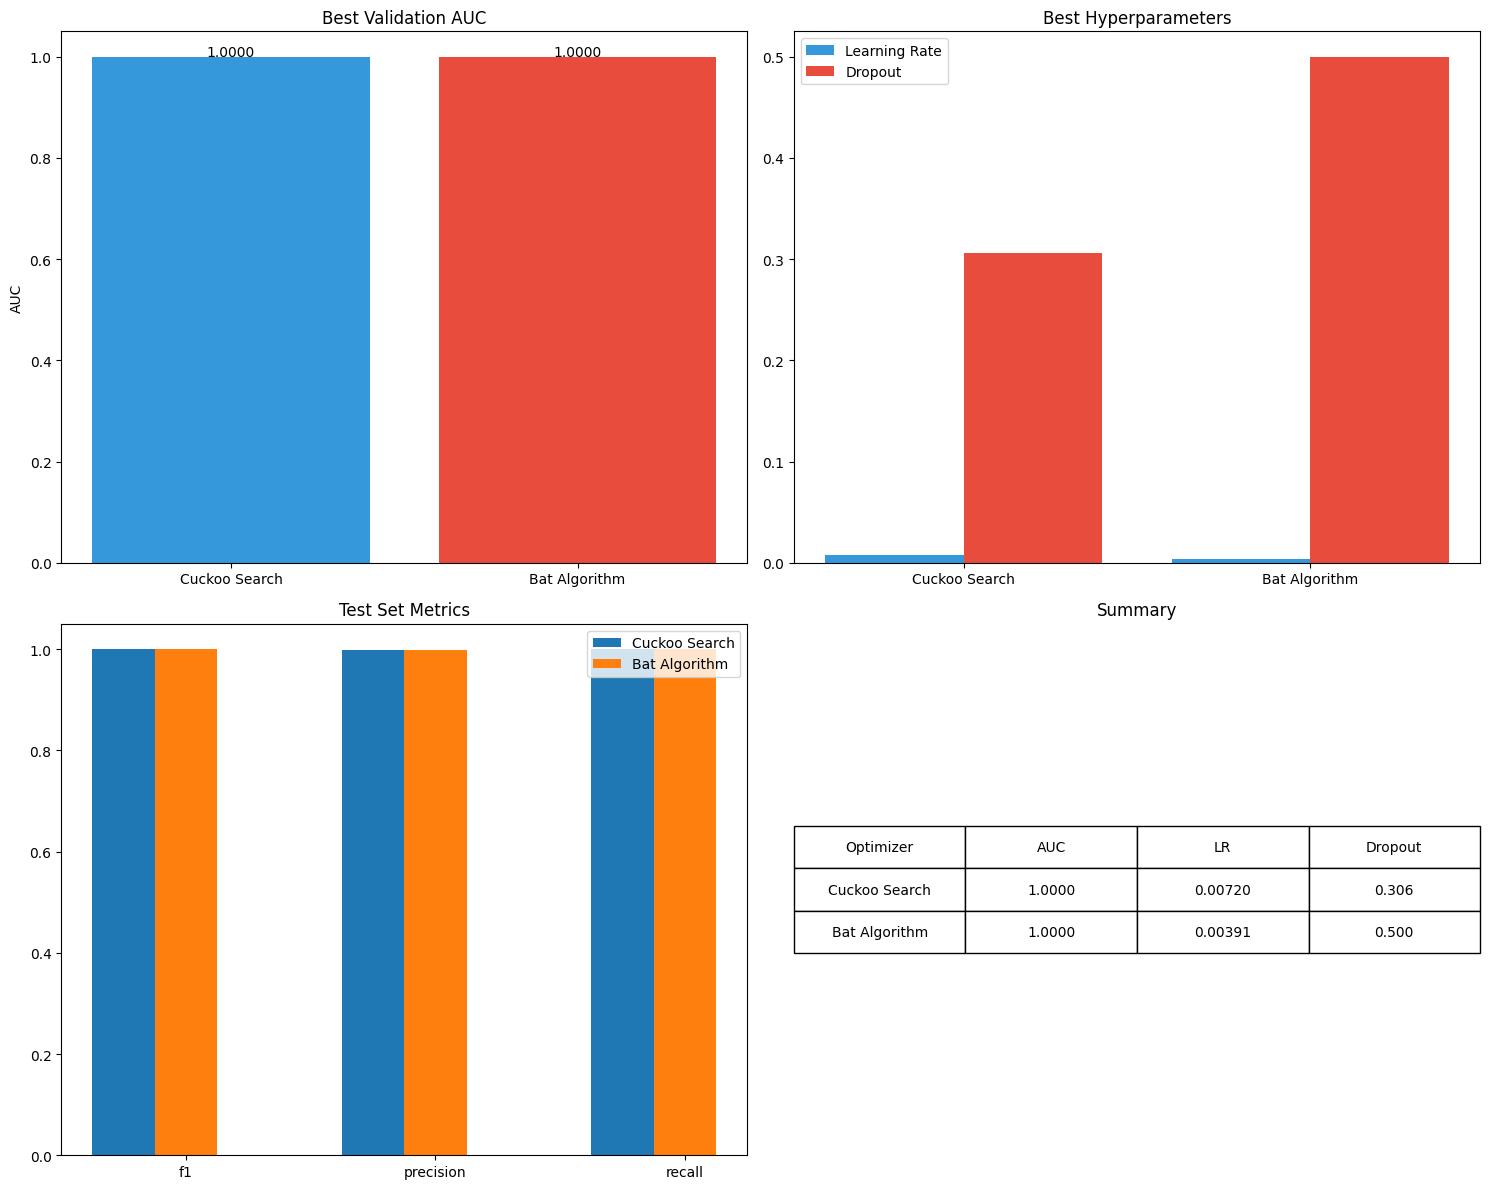


  BEST OPTIMIZER: Bat Algorithm (AUC = 1.0000)

🏆 BEST OPTIMIZER: Bat Algorithm (AUC = 1.0000)

Generating LIME explanation...
Using 2000 background points for LIME statistics
LIME explanation generated successfully!


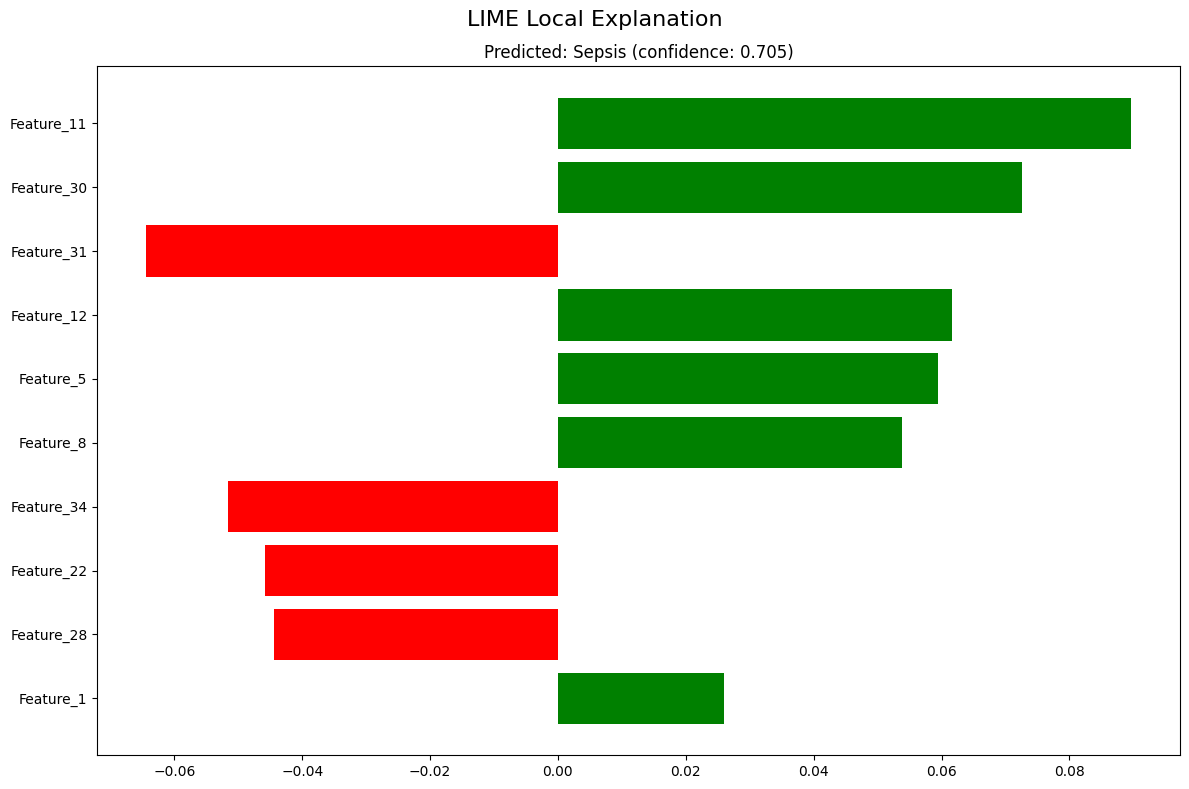


EXPERIMENT COMPLETE - CUCKOO SEARCH vs BAT ALGORITHM


In [20]:
n_features = X_scaled.shape[2]
results, best_model = run_optimization_experiment(X_scaled, y_all, n_features)


print("\n" + "="*60)
print("EXPERIMENT COMPLETE - CUCKOO SEARCH vs BAT ALGORITHM")
print("="*60)

In [24]:


print("All columns in df:")
print(df.columns.tolist())
print(f"Total columns: {len(df.columns)}")
print()


target_column = 'SepsisLabel'  


all_feature_cols = [col for col in df.columns if col != target_column]
print(f"Potential feature columns (excluding target): {len(all_feature_cols)}")
print(all_feature_cols)
print()


n_features_actual = X_scaled.shape[2]
print(f"Features actually used in model (X_scaled): {n_features_actual}")

used_feature_names = all_feature_cols[:n_features_actual]

print(f"\n FINAL MAPPING: Using first {n_features_actual} feature columns")
print("="*70)
print("Index → Real Name (as used in model)")
print("="*70)


lime_plot_indices_1based = [11, 30, 31, 12, 5, 8, 34, 22, 28, 1]

for plot_idx in sorted(lime_plot_indices_1based):
    if plot_idx <= n_features_actual:
        model_index_0based = plot_idx - 1
        real_name = used_feature_names[model_index_0based]
        print(f"Feature_{plot_idx}  →  {real_name:25}  (model index {model_index_0based})")
    else:
        print(f"Feature_{plot_idx}  →  [NOT USED IN MODEL - beyond {n_features_actual} features]")


All columns in df:
['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'BaseExcess', 'FiO2', 'pH', 'PaCO2', 'BUN', 'Calcium', 'Creatinine', 'Glucose', 'Magnesium', 'Potassium', 'Hct', 'Hgb', 'WBC', 'Platelets', 'Gender', 'ICULOS', 'SepsisLabel', 'Patient_ID', 'EtCO2_measured', 'HCO3_measured', 'SaO2_measured', 'AST_measured', 'Alkalinephos_measured', 'Chloride_measured', 'Bilirubin_direct_measured', 'Lactate_measured', 'Phosphate_measured', 'Bilirubin_total_measured', 'TroponinI_measured', 'PTT_measured', 'Fibrinogen_measured', 'DBP_measured']
Total columns: 39

Potential feature columns (excluding target): 38
['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'BaseExcess', 'FiO2', 'pH', 'PaCO2', 'BUN', 'Calcium', 'Creatinine', 'Glucose', 'Magnesium', 'Potassium', 'Hct', 'Hgb', 'WBC', 'Platelets', 'Gender', 'ICULOS', 'Patient_ID', 'EtCO2_measured', 'HCO3_measured', 'SaO2_measured', 'AST_measured', 'Alkalinephos_measured', 'Chloride_measured', 'Bilirubin_direct_measured', 'Lactate_me